In [30]:
# !pip install noisereduce -i https://mirrors.aliyun.com/pypi/simple/
# !pip install pandas -i https://mirrors.aliyun.com/pypi/simple/

In [51]:
device = 'cuda'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./../../BigVGAN/")
import torch
import bigvgan
import librosa
from meldataset import get_mel_spectrogram

sys.path.append("../../cuhksz-phd/sho_util/")
from pyfiles.sound import play_audio
from pyfiles.basic import plot_spectrogram

sys.path.append("../")
from pyfiles.processsound import trim_audio_and_save

# modelpath = "/mntcephfs/data/audiow/shoinoue/Model/hf_hub/bigvgan/models--nvidia--bigvgan_v2_24khz_100band_256x/snapshots/61df17db326f0876b7201d7a56c831898c836ef4"
modelpath = "/mntcephfs/data/audiow/shoinoue/Model/hf_hub/bigvgan/models--nvidia--bigvgan_v2_22khz_80band_fmax8k_256x/snapshots/189a02ed3b7957e8534b40e6314262df53536ece"
# instantiate the model. You can optionally set use_cuda_kernel=True for faster inference.
model = bigvgan.BigVGAN.from_pretrained(modelpath, use_cuda_kernel=False)
# remove weight norm in the model and set to eval mode
model.remove_weight_norm()
model = model.eval().to(device)

fs = 16000

Loading config.json from local directory
Loading weights from local directory
Removing weight norm...


In [52]:
# load wav file and compute mel spectrogram
tempfile = "temp3.wav"
wav_path = '/mntcephfs/lab_data/shoinoue/Dataset/CMU-ARCTIC/SLT/wav/arctic_a0001.wav'
trim_audio_and_save(wav_path, fs, savepath=tempfile, trim_threshold_in_db=30)
wav, sr = librosa.load(tempfile, sr=model.h.sampling_rate, mono=True) # wav is np.ndarray with shape [T_time] and values in [-1, 1]
wav = torch.FloatTensor(wav).unsqueeze(0) # wav is FloatTensor with shape [B(1), T_time]

# compute mel spectrogram from the ground truth audio
mel = get_mel_spectrogram(wav, model.h).to(device) # mel is FloatTensor with shape [B(1), C_mel, T_frame]

# generate waveform from mel
with torch.inference_mode():
    wav_gen = model(mel) # wav_gen is FloatTensor with shape [B(1), 1, T_time] and values in [-1, 1]
wav_gen_float = wav_gen.squeeze(0).cpu() # wav_gen is FloatTensor with shape [1, T_time]

# you can convert the generated waveform to 16 bit linear PCM
wav_gen_int16 = (wav_gen_float * 32767.0).numpy().astype('int16') # wav_gen is now np.ndarray with shape [1, T_time] and int16 dtype

<Axes: >

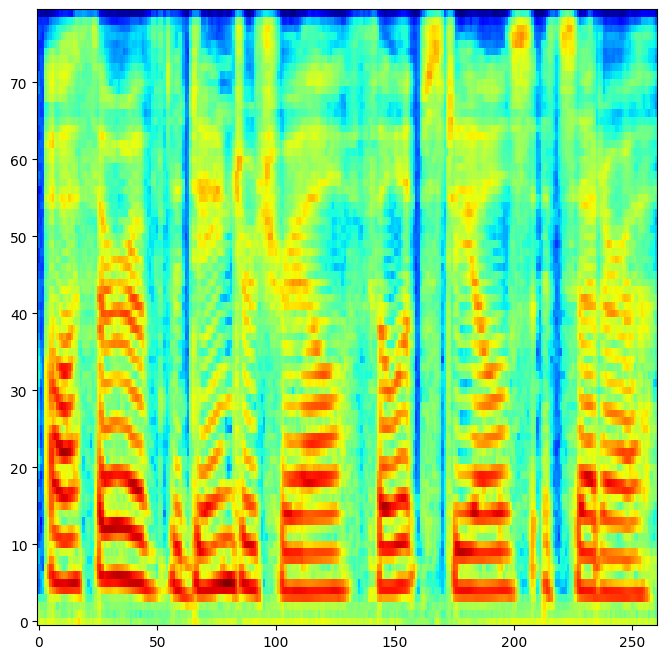

In [53]:
%matplotlib inline
plot_spectrogram(mel.detach().cpu().numpy()[0])

In [54]:
play_audio(wav_gen_int16, model.h.sampling_rate)